In [ ]:
import cv2
import h5py
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the images and labels from file
with h5py.File('/content/drive/MyDrive/Galaxy10.h5', 'r') as F:
    labels = np.array(F['ans'])
    images = np.array(F['images'])
#images = np.load('/content/drive/MyDrive/galaxy10sdss/masked_images/SDSSprocessed_images.npy')

import matplotlib.pyplot as plt

# Resize the images to (224, 224) and convert grayscale to RGB
#images = np.array([cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_GRAY2RGB) for img in images])
images = np.array([cv2.resize(img, (224, 224)) for img in images])
# Convert the labels to categorical 10 classes
labels = tf.keras.utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(images.shape)
print(labels.shape)
print(np.unique(labels, axis=0))




(21785, 224, 224, 3)
(21785, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
images = images/255

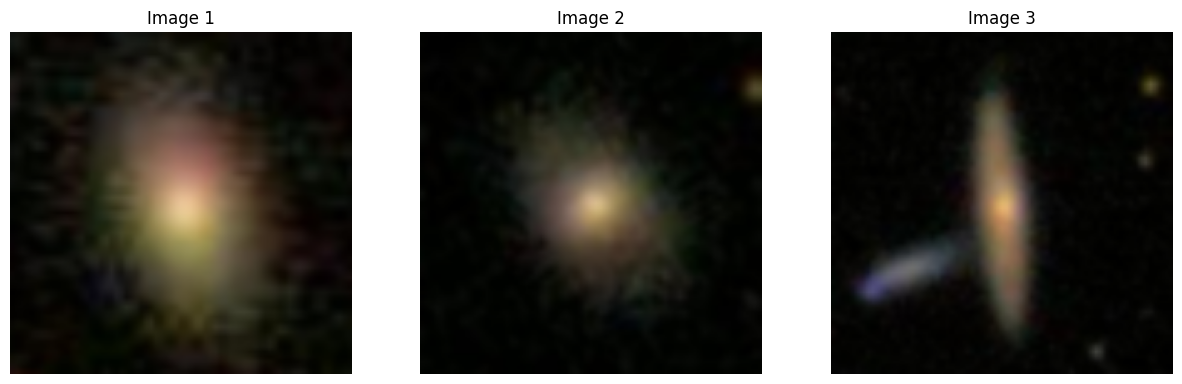

In [ ]:
import matplotlib.pyplot as plt
# Print the first 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Image {i+1}")
    ax.axis('off')
plt.show()

In [ ]:
# Split the data into train, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:

# Create ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Configure ImageDataGenerator for training data
datagen.fit(X_train)

# Load pre-trained VGG16 model with imagenet weights
weights = 'imagenet'
base_model = tf.keras.applications.VGG16(weights=weights, include_top=False)

# Add layers to the top of the model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation=LeakyReLU(), kernel_initializer='glorot_uniform', kernel_constraint=MaxNorm())(x)
x = Dropout(0.5)(x)
y = Dense(10, activation='softmax')(x)

# Define the final model and compile it
model = Model(inputs=base_model.input, outputs=y)

# Set up the learning rate schedule
initial_learning_rate = 1e-4
decay_steps = 1000
decay_rate = 0.9
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)

opt = Adam(learning_rate=lr_schedule)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(loss=loss, optimizer=opt, metrics=metrics)

# Define callbacks for early stopping and model checkpointing
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
mc = ModelCheckpoint('/content/drive/MyDrive/galaxy10sdss/best_modelSDSS_processed.h5', monitor='val_loss', mode='min', save_best_only=True)

# Train the newly added top layers for 10 epochs with the convolutional part frozen
model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[es, mc]
)


# Unfreeze the last 7 layers and train the entire network for up to 200 epochs
for layer in base_model.layers[:-7]:
    layer.trainable = False
for layer in base_model.layers[-7:]:
    layer.trainable = True

model.compile(loss=loss, optimizer=opt, metrics=metrics)

# Train the model with early stopping and model checkpointing
model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[es, mc]
)


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/10
476/476 [==============================] - 177s 334ms/step - loss: 1.2985 - accuracy: 0.4873 - val_loss: 0.7879 - val_accuracy: 0.7001
Epoch 2/10
476/476 [==============================] - 156s 327ms/step - loss: 0.8449 - accuracy: 0.6796 - val_loss: 0.7059 - val_accuracy: 0.7362
Epoch 3/10
476/476 [==============================] - 156s 327ms/step - loss: 0.7070 - accuracy: 0.7352 - val_loss: 0.6829 - val_accuracy: 0.7427
Epoch 4/10
476/476 [==============================] - 155s 326ms/step - loss: 0.6489 - accuracy: 0.7630 - val_loss: 0.6242 - val_accuracy: 0.7785
Epoch 5/10
476/476 [==============================] - 158s 331ms/step - loss: 0.5823 - accuracy: 0.7860 - val_loss: 0.4996 - val_accuracy: 0.8244
Epoch 6/10
476/476 [==============================] - 156s 327ms/step - loss: 0.5498 - accuracy: 0.8017 - val_loss: 0.5409 - val_accuracy: 0.8017
Epoch 7/10
476/476 [==============================] - 160s 

103/103 [==============================] - 11s 23ms/step


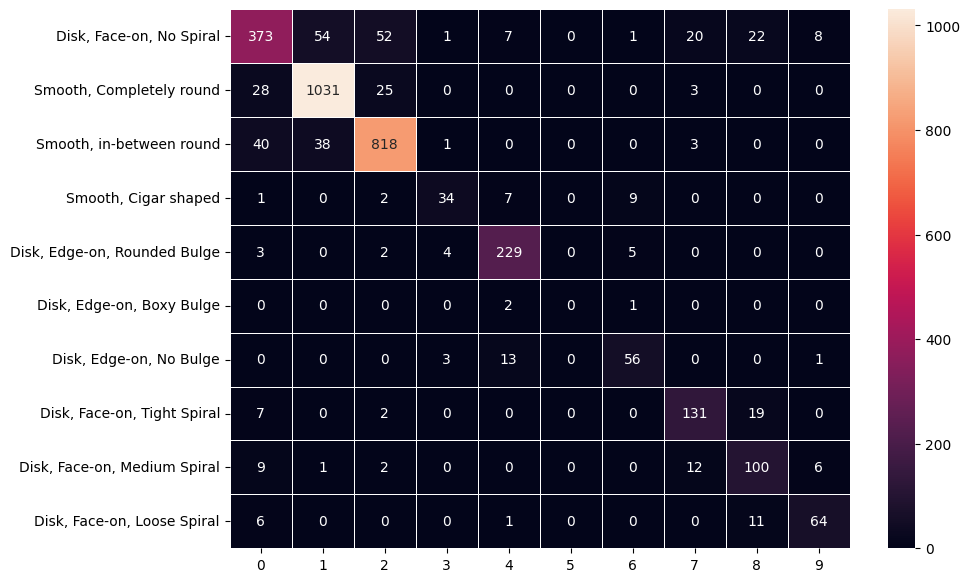

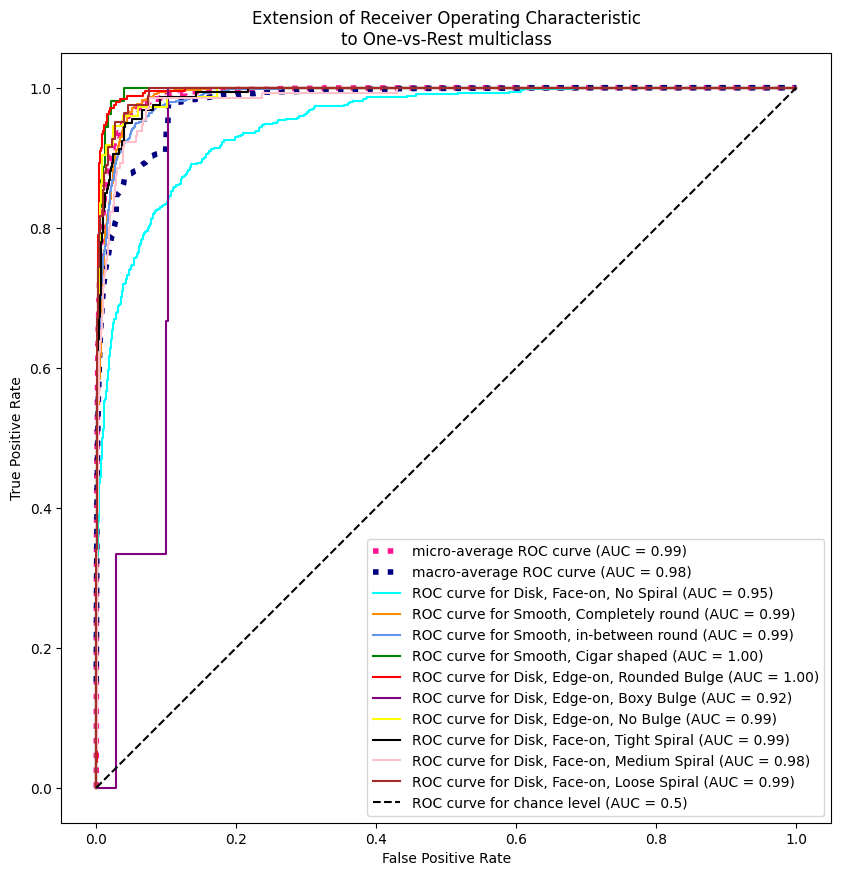

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
import pandas as pd
import numpy as np
# Load the best saved model
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/MyDrive/galaxy10sdss/best_modelSDSS_processed.h5')
# Define class names
class_names = ['Disk, Face-on, No Spiral',
              'Smooth, Completely round',
              'Smooth, in-between round',
              'Smooth, Cigar shaped',
              'Disk, Edge-on, Rounded Bulge',
              'Disk, Edge-on, Boxy Bulge',
              'Disk, Edge-on, No Bulge',
              'Disk, Face-on, Tight Spiral',
              'Disk, Face-on, Medium Spiral',
              'Disk, Face-on, Loose Spiral']

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Convert predictions to actual class labels
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_actual_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_actual_classes, y_test_pred_classes)

val_matrix = pd.DataFrame(cm, index = class_names, columns = [i for i in range(10)])

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(val_matrix, annot=True,fmt='.0f', linewidths=.5, ax=ax)

# ROC and AUC
n_classes = 10
y_pred_val = y_test_pred
y_val = y_test

fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_pred_val.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Interpolate all ROC curves
fpr_grid = np.linspace(0.0, 1.0, 1000)
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig, ax = plt.subplots(figsize=(10, 10))

plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})", color="deeppink", linestyle=":", linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})", color="navy", linestyle=":", linewidth=4)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "red", "purple", "yellow", "black", "pink", "brown"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(y_val[:, class_id], y_pred_val[:, class_id], name=f"ROC curve for {class_names[class_id]}", color=color, ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Classification Report
print("Classification Report:\n", classification_report(y_test_actual_classes, y_test_pred_classes, target_names=class_names))

Classification Report:
                               precision    recall  f1-score   support

    Disk, Face-on, No Spiral       0.80      0.69      0.74       538
    Smooth, Completely round       0.92      0.95      0.93      1087
    Smooth, in-between round       0.91      0.91      0.91       900
        Smooth, Cigar shaped       0.79      0.64      0.71        53
Disk, Edge-on, Rounded Bulge       0.88      0.94      0.91       243
   Disk, Edge-on, Boxy Bulge       0.00      0.00      0.00         3
     Disk, Edge-on, No Bulge       0.78      0.77      0.77        73
 Disk, Face-on, Tight Spiral       0.78      0.82      0.80       159
Disk, Face-on, Medium Spiral       0.66      0.77      0.71       130
 Disk, Face-on, Loose Spiral       0.81      0.78      0.80        82

                    accuracy                           0.87      3268
                   macro avg       0.73      0.73      0.73      3268
                weighted avg       0.87      0.87      0.87     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
